In [1]:
import torch
import torchvision as tv
import torchvision.transforms as transforms
from torchvision.datasets.vision import StandardTransform
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import pandas as pd 
from PIL import Image
import matplotlib.pyplot as plt 
%matplotlib inline 
import json
import os

import SimpleITK as sitk

#from Dataset_Utils import BraTS_TrainingDataset
#from Dataset_Utils import BraTS_TestDataset
#from Dataset_Utils import plot_batch

## Architecture

<img src="Lecture_Architecture.png" alt="Lecture_Architecture" width="400"/>

In [2]:
class SmallSegNet(nn.Module):
    
    def __init__(self, in_channels=4, num_classes=4, img_height=5, img_width=5):
        super(SmallSegNet, self).__init__()
        self.sm = nn.Softmax(dim=0)
        self.layers = nn.Sequential(
        
        # decrease x,y and increase channels
            # Conv
            nn.Conv2d(in_channels,4,2,stride=1,padding=0),
            # nn.Batchnorm
            nn.ReLU(),
        
        # change number of channels
            # 1x1 Conv
            nn.Conv2d(4,num_classes*2,1,stride=1,padding=0),
            # nn.Batchnorm
            nn.ReLU(),
        
        # increase x,y and decrease channels
            # Transpose-Conv
            nn.ConvTranspose2d(num_classes*2, num_classes, 2, stride=1, padding=0)
        )
    
    def forward(self, x):
        x = torch.FloatTensor(x)
        x = self.layers(x)
        # x = self.sm(x)
        # Skip Softmax because Torch CrossEntropyLoss
        # takes logits and already applies Softmax.
        return x

# summary
# print(SmallSegNet())

model = SmallSegNet(in_channels=1, num_classes=4, img_height=5, img_width=5)

In [3]:
x = np.random.randint(2, size=(5,5))
print('input img:')
print(x)

y_hat = model.forward(x[None,:])
y_hat

input img:
[[1 1 0 1 0]
 [1 0 0 0 0]
 [1 0 0 0 1]
 [1 1 1 0 1]
 [0 1 0 1 0]]


tensor([[[-0.2904, -0.4218, -0.3541, -0.4042, -0.3024],
         [-0.4086, -0.3836, -0.2520, -0.3435, -0.1339],
         [-0.3972, -0.2626, -0.3221, -0.2970, -0.2199],
         [-0.3539, -0.2423, -0.3733, -0.2767, -0.2373],
         [-0.2753, -0.2215, -0.2331, -0.1676, -0.1880]],

        [[ 0.2003,  0.0898,  0.1254,  0.0838,  0.1532],
         [ 0.0766, -0.0092,  0.0352,  0.0470,  0.1396],
         [ 0.0809,  0.0245,  0.0411,  0.0478,  0.1368],
         [ 0.1031,  0.0733,  0.0132,  0.0695,  0.1488],
         [ 0.1643,  0.1269,  0.0959,  0.1260,  0.1372]],

        [[ 0.0290,  0.1543,  0.0189,  0.1070, -0.0023],
         [ 0.0325, -0.1307, -0.0250, -0.0924, -0.0066],
         [-0.0029, -0.0748, -0.0465, -0.0557, -0.0400],
         [-0.0245, -0.1211, -0.0224, -0.1244,  0.0275],
         [-0.0404, -0.0804, -0.1662, -0.0716, -0.0850]],

        [[-0.2068, -0.1510, -0.0516, -0.1685,  0.0208],
         [-0.2615,  0.1108,  0.0618,  0.0459,  0.1334],
         [-0.2571,  0.1265,  0.0436,  0.09

tensor([[0.2003, 0.1543, 0.1254, 0.1070, 0.1532],
        [0.0766, 0.1108, 0.0618, 0.0470, 0.1396],
        [0.0809, 0.1265, 0.0436, 0.0931, 0.1368],
        [0.1031, 0.1100, 0.0473, 0.1244, 0.1488],
        [0.1643, 0.1269, 0.0959, 0.1260, 0.1372]], grad_fn=<MaxBackward0>)
tensor([[1, 2, 1, 2, 1],
        [1, 3, 3, 1, 1],
        [1, 3, 3, 3, 1],
        [1, 3, 3, 3, 1],
        [1, 1, 1, 1, 1]])


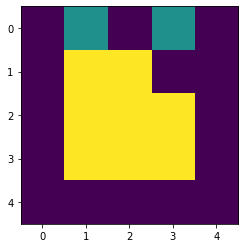

In [4]:
probs, out = torch.max(y_hat, dim=0)
print(probs)
print(out)
plt.imshow(out)

## Crossentropy Loss

In [5]:
label =  torch.tensor(
       [[3, 1, 1, 1, 3],
        [3, 3, 0, 3, 1],
        [0, 3, 2, 2, 3],
        [1, 0, 0, 2, 3],
        [0, 0, 3, 3, 3]])

In [6]:
# Crossentropy Loss
criterion = nn.CrossEntropyLoss()

In [7]:
print(y_hat.shape)
y_hat_batch = y_hat[None,:]
print(y_hat_batch.shape)

print(label.shape)
label_batch = label[None,:]
print(label_batch.shape)

torch.Size([4, 5, 5])
torch.Size([1, 4, 5, 5])
torch.Size([5, 5])
torch.Size([1, 5, 5])


In [8]:
loss = criterion(y_hat_batch, label_batch)
loss

tensor(1.3906, grad_fn=<NllLoss2DBackward0>)

Training loop: Overfitting to one sample

In [9]:
optim = torch.optim.Adam(model.parameters(), lr=0.1)

In [10]:
# training loop
epochs = 100
losses = []
for epoch in range(epochs):
    # get output
    pixel_logits = model.forward(x[None,:])
    pixel_logits_batch = pixel_logits[None,:]
    
    # get loss
    loss = criterion(pixel_logits_batch, label_batch)
    losses.append(loss)
    
    # backprop loss
    optim.zero_grad()
    loss.backward()
    optim.step()

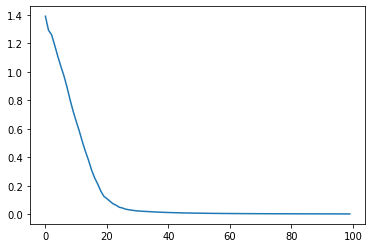

In [11]:
losses_array = [l.detach().numpy() for l in losses]
plt.plot(losses_array)

tensor([[0.9999, 1.0000, 0.9997, 1.0000, 0.9549],
        [0.9999, 1.0000, 1.0000, 0.9999, 0.9981],
        [0.9999, 0.9999, 0.9999, 0.9999, 0.9999],
        [1.0000, 1.0000, 1.0000, 0.9999, 1.0000],
        [0.9999, 1.0000, 1.0000, 1.0000, 1.0000]], grad_fn=<MaxBackward0>)
tensor([[3, 1, 1, 1, 3],
        [3, 3, 0, 3, 1],
        [0, 3, 2, 2, 3],
        [1, 0, 0, 2, 3],
        [0, 0, 3, 3, 3]])


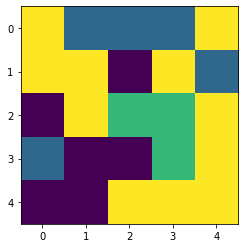

In [12]:
pixel_logits = model.forward(x[None,:])
sm = nn.Softmax(dim=0)
pixel_probs = sm(pixel_logits)
probs, out = torch.max(pixel_probs, dim=0)
print(probs)
print(out)
plt.imshow(out)

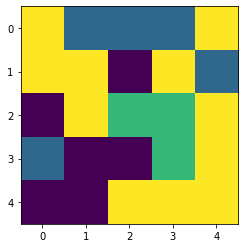

In [13]:
plt.imshow(label)

In [14]:
# save params
# torch.save(model.state_dict(), 'SmallSegNet.pt')

# load params
# model = SmallSegNet()
# model.load_state_dict(torch.load('SmallSegNet.pt'))
# model.eval()